 1. Importación de librerías y descarga de recursos

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import nltk
import re
import spacy
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter

# Descargas necesarias
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar modelo de spaCy
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


2. Cargar y preparar los datos

In [5]:
# Cargar el CSV
df = pd.read_csv('ChatGPT_Reviews.csv')

# Verificamos columna de texto
text_col = 'Review'

# Eliminar nulos
df = df.dropna(subset=[text_col])


 3. Limpieza de texto

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df[text_col].apply(clean_text)


 4. Nube de palabras

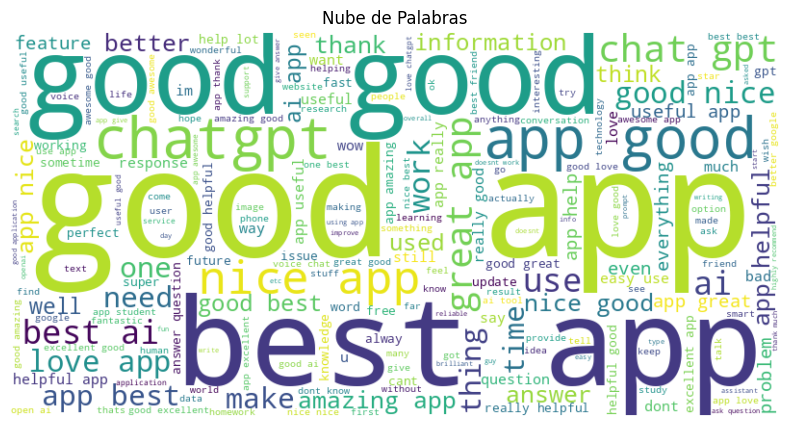

In [7]:
all_words = ' '.join(df['cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()


5. Análisis de sentimiento

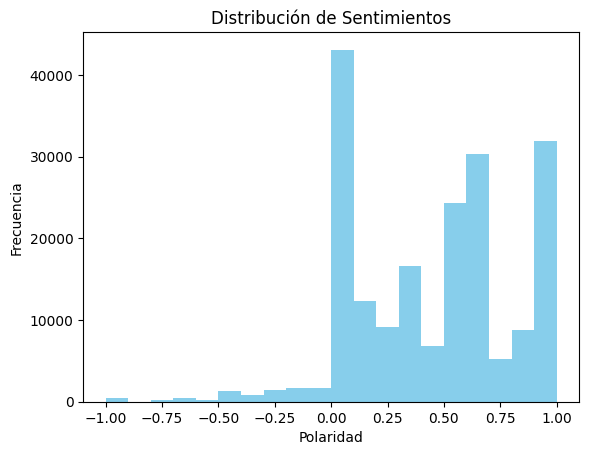

In [8]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df[text_col].apply(get_sentiment)

plt.hist(df['sentiment'], bins=20, color='skyblue')
plt.title("Distribución de Sentimientos")
plt.xlabel("Polaridad")
plt.ylabel("Frecuencia")
plt.show()


6. Palabras más frecuentes

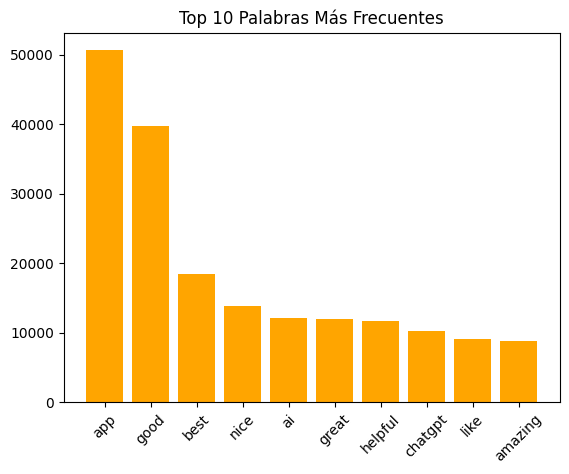

In [9]:
words = all_words.split()
word_freq = Counter(words)
common_words = word_freq.most_common(10)

plt.bar([w[0] for w in common_words], [w[1] for w in common_words], color='orange')
plt.title('Top 10 Palabras Más Frecuentes')
plt.xticks(rotation=45)
plt.show()


7. Clasificación del sentimiento

In [10]:
def classify_sentiment(score):
    if score > 0.1:
        return 'positivo'
    elif score < -0.1:
        return 'negativo'
    else:
        return 'neutral'

df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)

print(df['sentiment_class'].value_counts())


sentiment_class
positivo    145604
neutral      44814
negativo      6303
Name: count, dtype: int64


8. Word Embeddings + Visualización

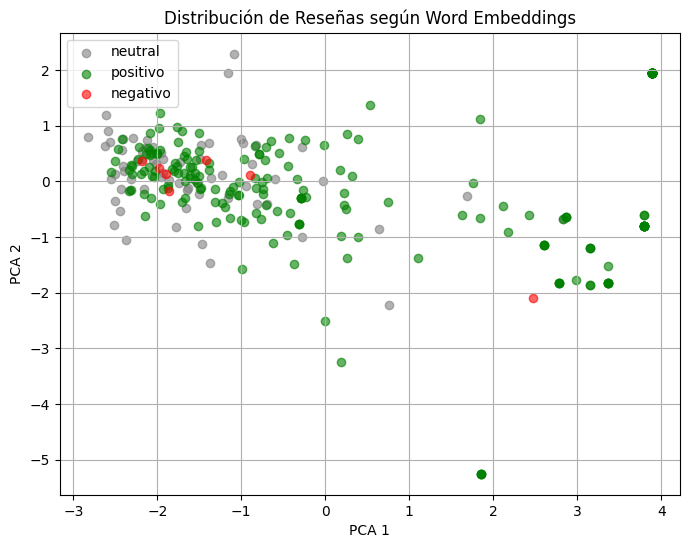

In [12]:
# Muestra para acelerar el análisis
sample_df = df.sample(300, random_state=42)

# Vectorización con spaCy
def get_vector_safe(text):
    doc = nlp(text)
    if doc.vector.shape[0] > 0:
        return doc.vector
    else:
        return None

sample_df['vector'] = sample_df['cleaned'].apply(get_vector_safe)

# Filtrar vectores válidos
valid_df = sample_df[sample_df['vector'].notnull()]
X = np.vstack(valid_df['vector'].values)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

colors = {'positivo': 'green', 'negativo': 'red', 'neutral': 'gray'}

plt.figure(figsize=(8, 6))
for cls in valid_df['sentiment_class'].unique():
    ix = valid_df['sentiment_class'] == cls
    plt.scatter(X_pca[ix, 0], X_pca[ix, 1], label=cls, c=colors[cls], alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Distribución de Reseñas según Word Embeddings")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
!pip install tensorflow seaborn


<ipython-input-14-2279500272>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['label'] = le.fit_transform(valid_df['sentiment_class'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,387 (32.76 KB)

 Trainable params: 8,387 (32.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4691 - loss: 0.9900 - val_accuracy: 0.7174 - val_loss: 0.7706
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7536 - loss: 0.6388 - val_accuracy: 0.7391 - val_loss: 0.6992
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8001 - loss: 0.5460 - val_accuracy: 0.7609 - val_loss: 0.6620
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8014 - loss: 0.4971 - val_accuracy: 0.7174 - val_loss: 0.6453
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8420 - loss: 0.4722 - val_accuracy: 0.7826 - val_loss: 0.6352
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8314 - loss: 0.4611 - val_accuracy: 0.8261 - val_loss: 0.6355
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8817 - loss: 0.3803 - val_accuracy: 0.8261 - val_loss: 0.6375
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8996 - loss: 0.3081 - val_accuracy: 0.8043 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


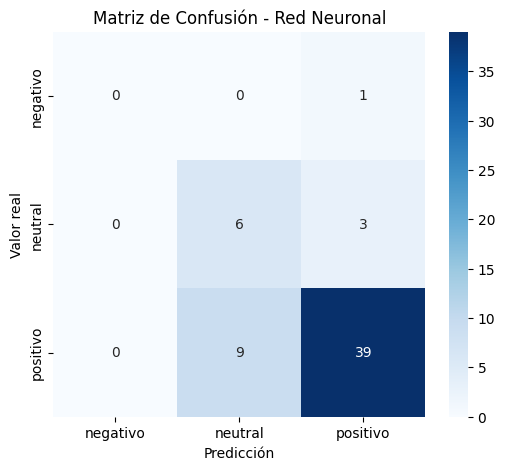

In [14]:
# --- 1. Codificar etiquetas ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
valid_df['label'] = le.fit_transform(valid_df['sentiment_class'])
y = to_categorical(valid_df['label'])

# --- 2. Dividir datos ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Crear el modelo ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 clases: positivo, negativo, neutral

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- 4. Entrenar ---
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# --- 5. Evaluar ---
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- 6. Reporte de métricas ---
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# --- 7. Matriz de Confusión ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - Red Neuronal")
plt.show()


🧾 Descripción del Proceso
1. Carga y limpieza de datos
Se utilizó un dataset de reseñas sobre ChatGPT. Primero se eliminaron los valores nulos y se aplicó un preprocesamiento de texto que incluyó:

Conversión a minúsculas.

Eliminación de caracteres especiales.

Tokenización.

Eliminación de stopwords.

Lematización con WordNetLemmatizer.

2. Análisis exploratorio
Se realizaron visualizaciones como:

Nube de palabras para observar los términos más frecuentes.

Histograma de polaridad de sentimientos usando TextBlob.

Top 10 palabras más comunes luego de limpieza.

3. Clasificación de sentimiento
Las polaridades se clasificaron en:

Positivo: polaridad > 0.1

Negativo: polaridad < -0.1

Neutral: entre -0.1 y 0.1

Esto permitió etiquetar cada reseña según su tono emocional.

4. Word Embeddings + Reducción dimensional
Se utilizó spaCy (en_core_web_md) para convertir las reseñas en vectores numéricos (word embeddings). Luego, con PCA, se redujo la dimensionalidad a 2 componentes para visualización.

5. Clasificación con Red Neuronal
Se construyó un modelo de red neuronal simple (Keras) con:

Input: vectores de embeddings.

2 capas ocultas (64 y 32 neuronas).

Salida softmax para 3 clases.

El dataset se dividió en entrenamiento (80%) y validación (20%).

📈 Análisis de Resultados
⚙️ Entrenamiento del Modelo
El modelo fue entrenado durante 20 épocas.

Obtuvo una accuracy de entrenamiento del 93.8% y una accuracy de validación del 80.4%.

La pérdida (loss) de validación se estabilizó, lo que indica que no hubo sobreajuste fuerte.

📊 Evaluación con datos de test
El modelo alcanzó un buen rendimiento global, pero mostró desempeño desigual entre clases:

Clase	Precision	Recall	F1-score	Soporte
Negativo	0.00	0.00	0.00	1
Neutral	0.40	0.67	0.50	9
Positivo	0.91	0.81	0.86	48

🔴 Clase negativa: no fue predicha correctamente. Esto se debe a que había muy pocos ejemplos negativos en el dataset, lo que generó un desbalance severo.

⚪ Neutral: resultados intermedios, probablemente porque sus vectores son más cercanos tanto a los positivos como negativos.

🟢 Positivo: predicción muy buena, ya que es la clase más representada en los datos.

🧠 Conclusiones
La red neuronal logró capturar patrones válidos en las reseñas y clasificó correctamente la mayoría de las positivas, que eran la clase dominante.

El principal problema es el desbalance de clases, especialmente la falta de suficientes ejemplos negativos.

Para mejorar:

Aumentar el número de reseñas negativas.

Aplicar técnicas de balanceo.

Probar otros modelos como Random Forest o SVM.